In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split


In [171]:
# Load the data
data = pd.read_csv('historical stock data/tesla_data.csv')

# Reverse the rows
tesla_data = data.iloc[::-1].reset_index(drop=True)
#reading the date column by converting to date time format
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

In [173]:
# Columns to be cleaned
columns_to_clean = ['Open', 'Close/Last', 'High', 'Low']

# Remove dollar signs and convert to numeric for each specified column
for column in columns_to_clean:
    tesla_data[column] = tesla_data[column].astype(str).str.replace('[$,]', '', regex=True)
    tesla_data[column] = pd.to_numeric(tesla_data[column], errors='coerce')

# Extract the 'Close' prices
close_prices = tesla_data['Close/Last'].values.reshape(-1, 1)

scaler = MinMaxScaler()
tesla_scaled = tesla_data.copy()
columns = ['Close/Last']
tesla_scaled[columns] = scaler.fit_transform(tesla_data[columns])
tesla_scaled.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-07-11,0.012398,49491275,14.7073,14.7733,14.5067
2014-07-14,0.013825,107969721,14.6660,15.2527,14.3634
2014-07-15,0.012639,85719122,15.1153,15.1767,14.5400
2014-07-16,0.012236,60625005,14.7880,14.9867,14.4547
2014-07-17,0.011943,69712720,14.4107,14.7033,14.2400


In [175]:
tesla_scaled.drop(columns=['Volume', 'Open','High','Low'], inplace=True)
# Define training data length about 80 percent train data
training_data_len = 2016

# Split the data
train_data = tesla_scaled[0:training_data_len]
test_data = tesla_scaled[training_data_len:]


In [177]:
train_data

,Close/Last
Date,
2014-07-11,0.012398
2014-07-14,0.013825
2014-07-15,0.012639
2014-07-16,0.012236
2014-07-17,0.011943
...,...
2022-07-07,0.586838
2022-07-08,0.602373
2022-07-11,0.561363


In [179]:
# Ensure train_data and test_data are numpy arrays
train_data = train_data.values
test_data = test_data.values

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 63
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [181]:
len(X_train)

1953

In [183]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [185]:
# Build the GRU model
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [187]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.0203 - val_loss: 7.2684e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0012 - val_loss: 6.3938e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0011 - val_loss: 6.0176e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0011 - val_loss: 6.4506e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0010 - val_loss: 5.9053e-04
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 8.5988e-04 - val_loss: 6.1460e-04
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 9.0057e-04 - val_loss: 6.3138e-04
Epoch 12/50
62/62 ━━━━━━━

In [139]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


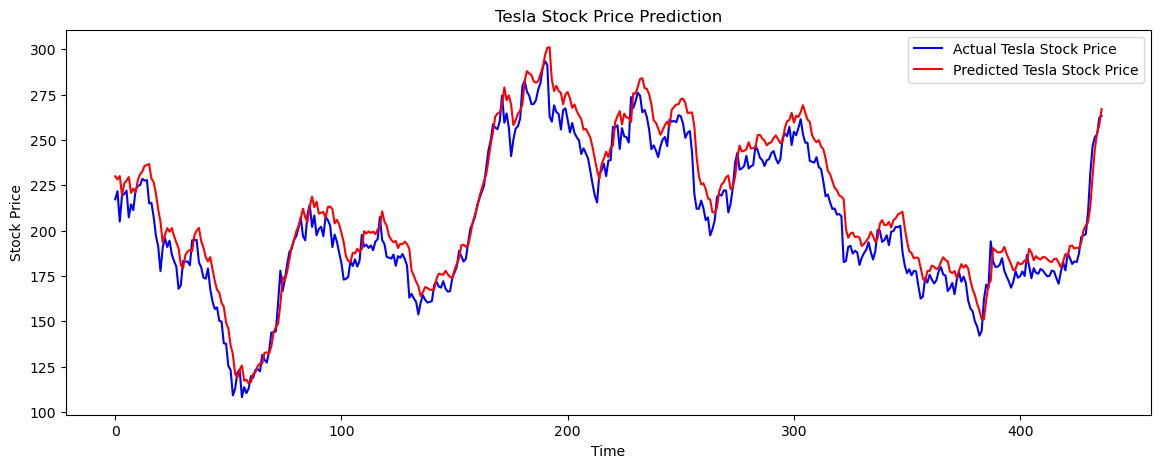

In [141]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [163]:
# Get the actual prices
actual_prices = tesla_data['Close/Last'][training_data_len + seq_length:].values
# Adjust the valid DataFrame to match the length of predictions
valid = tesla_data[training_data_len + seq_length:].copy()
valid['Predictions'] = predictions
valid

,Close/Last,Volume,Open,High,Low,Predictions
Date,,,,,,
2022-10-12,217.24,66860700,215.33,219.2999,211.5100,229.932358
2022-10-13,221.72,91483050,208.30,222.9900,206.2200,228.206680
2022-10-14,204.99,94124510,224.01,226.2600,204.1600,230.056458
2022-10-17,219.35,79428810,210.04,221.8600,209.4500,219.487259
2022-10-18,220.19,75891910,229.50,229.8200,217.2500,225.919464
...,...,...,...,...,...,...
2024-07-03,246.39,166561500,234.56,248.3500,234.2500,229.599503
2024-07-05,251.52,154501200,249.81,252.3700,242.4601,244.727737
2024-07-08,252.94,157219600,247.71,259.4390,244.5700,253.596344


In [165]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Print the evaluation results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Squared Error (MSE): 130.72147282095477
Mean Absolute Error (MAE): 9.488329358133628
Mean Absolute Percentage Error (MAPE): 4.784335315801334%


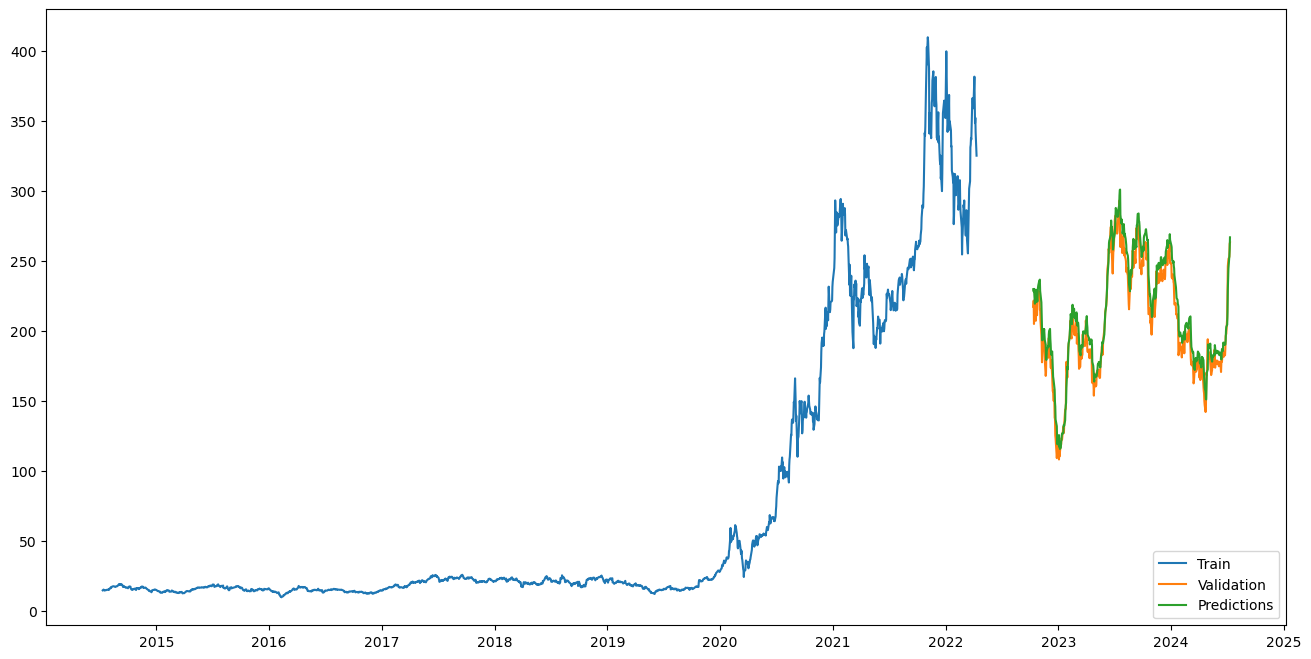

In [167]:
# Plot the results
train = tesla_data[:len(X_train)]

plt.figure(figsize=(16,8))
plt.plot(train['Close/Last'], label='Train')
plt.plot(valid[['Close/Last']], label='Validation')
plt.plot(valid[['Predictions']], label='Predictions') 
plt.legend(loc='lower right')
plt.show()